In [29]:
!pip install pennylane qiskit numpy matplotlib qiskit-aer qiskit-ibm-runtime pycryptodome

In [30]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import Sampler
from qiskit import QuantumCircuit
from qiskit_aer import Aer
import numpy as np
import matplotlib.pyplot as plt
# Angles in radians
alice_angles = [0, np.pi/4, np.pi/2]
bob_angles   = [np.pi/8, 3*np.pi/8, 5*np.pi/8]

def apply_measurement_basis(circuit, qubit, angle):
    circuit.ry(-2 * angle, qubit)


def run_e91_round(alice_angle, bob_angle):
    qc = QuantumCircuit(2, 2)

    # Step 1: Create Bell pair
    qc.h(0)
    qc.cx(0, 1)

    # Step 2: Apply measurement basis rotations
    qc.ry(-2 * alice_angle, 0)
    qc.ry(-2 * bob_angle, 1)

    # Step 3: Measure both qubits
    qc.measure(0, 0)
    qc.measure(1, 1)

    # Step 4: Run simulation
    backend = Aer.get_backend('qasm_simulator')
    job = backend.run(qc, shots=1)
    result = job.result()
    counts = result.get_counts()

    # Extract the single measurement result
    outcome = list(counts.keys())[0]
    return int(outcome[1]), int(outcome[0])  # (Alice, Bob)



In [31]:
num_rounds = 5000
results = []

for _ in range(num_rounds):
    a_idx = np.random.randint(0, 3)
    b_idx = np.random.randint(0, 3)

    alice_angle = alice_angles[a_idx]
    bob_angle   = bob_angles[b_idx]

    a_result, b_result = run_e91_round(alice_angle, bob_angle)

    results.append({
        'a_idx': a_idx,
        'b_idx': b_idx,
        'a_result': a_result,
        'b_result': b_result
    })


In [32]:
from collections import defaultdict

def compute_correlation(results, a_idx, b_idx):
    N = defaultdict(int)

    for r in results:
        if r['a_idx'] == a_idx and r['b_idx'] == b_idx:
            key = (r['a_result'], r['b_result'])
            N[key] += 1

    total = sum(N.values())
    if total == 0:
        return 0

    # Correlation formula
    correlation = (N[(0,0)] + N[(1,1)] - N[(0,1)] - N[(1,0)]) / total
    return correlation


In [33]:
# Choose angles that match CHSH S combination
# a0 = 0, a1 = 1; b0 = 0, b1 = 1

E00 = compute_correlation(results, 0, 0)
E01 = compute_correlation(results, 0, 1)
E10 = compute_correlation(results, 1, 0)
E11 = compute_correlation(results, 1, 1)

S = E00 + E01 + E10 - E11
print(f"CHSH S-value: {S:.3f}")


CHSH S-value: -0.040


In [34]:
raw_key = []

for r in results:
    if r['a_idx'] == 2 and r['b_idx'] == 2:
        if r['a_result'] == r['b_result']:
            raw_key.append(r['a_result'])

print(f"Raw key bits: {raw_key}")
print(f"Key length: {len(raw_key)}")


Raw key bits: [0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1

In [35]:
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from Crypto.Hash import SHA256
import binascii

raw_key_bits = raw_key

# Step 1: Convert bit list to byte string
def bits_to_bytes(bits):
    bit_str = ''.join(str(b) for b in bits)
    # Pad to nearest byte
    bit_str = bit_str + '0' * ((8 - len(bit_str) % 8) % 8)
    return bytes(int(bit_str[i:i+8], 2) for i in range(0, len(bit_str), 8))

key_material = bits_to_bytes(raw_key_bits)

# Step 2: Hash to 256-bit AES key using SHA-256
sha = SHA256.new()
sha.update(key_material)
aes_key = sha.digest()  # 32 bytes = 256 bits

print("AES Key:", binascii.hexlify(aes_key).decode())

# Step 3: Encrypt a message using AES-256-GCM
plaintext = b"Hello from E91 QKD + AES!"
nonce = get_random_bytes(12)  # GCM standard nonce size
cipher = AES.new(aes_key, AES.MODE_GCM, nonce=nonce)
ciphertext, tag = cipher.encrypt_and_digest(plaintext)

print("Ciphertext:", binascii.hexlify(ciphertext).decode())
print("Tag:", binascii.hexlify(tag).decode())
print("Nonce:", binascii.hexlify(nonce).decode())

# Step 4: Decrypt and verify
decrypt_cipher = AES.new(aes_key, AES.MODE_GCM, nonce=nonce)
decrypted = decrypt_cipher.decrypt_and_verify(ciphertext, tag)

print("Decrypted message:", decrypted.decode())


AES Key: 666179bee67a61701066b724cd5612cc3c781b82ab0d95a388f3aad3a16fd4ef
Ciphertext: 26bcd06cb094752f8a52203ab5f818da1ddbacd59cdb7aa3d0
Tag: 4c0f9452d8c143e5251ab06ade900780
Nonce: 6c5871fd43e92367e994dcd9
Decrypted message: Hello from E91 QKD + AES!


In [36]:
# Estimate QBER
mismatches = 0
total_key_bits = 0

for r in results:
    if r['a_idx'] == 2 and r['b_idx'] == 2:
        total_key_bits += 1
        if r['a_result'] != r['b_result']:
            mismatches += 1

if total_key_bits > 0:
    qber = mismatches / total_key_bits
    print(f"QBER: {qber:.2%}")


QBER: 14.15%


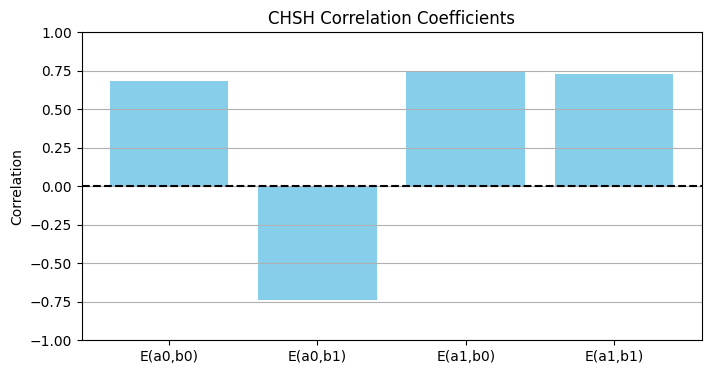

In [37]:
# After computing the correlations (E00, E01, E10, E11)
correlations = [E00, E01, E10, E11]
labels = ["E(a0,b0)", "E(a0,b1)", "E(a1,b0)", "E(a1,b1)"]

plt.figure(figsize=(8, 4))
plt.bar(labels, correlations, color='skyblue')
plt.axhline(0, color='black', linestyle='--')
plt.title("CHSH Correlation Coefficients")
plt.ylabel("Correlation")
plt.ylim(-1, 1)
plt.grid(axis='y')
plt.show()


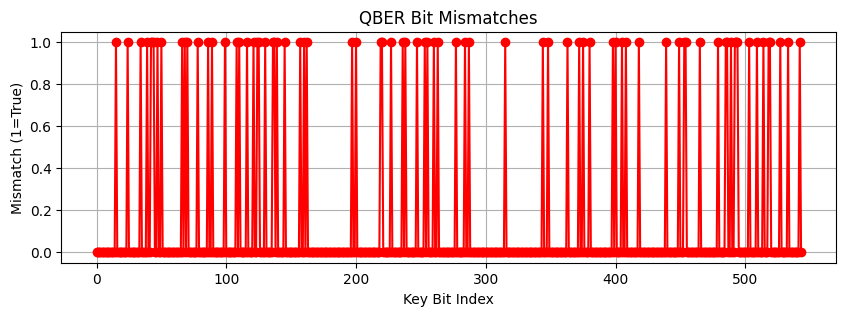

In [38]:
# Let's visualize which bits matched/mismatched (0 = match, 1 = mismatch)
mismatch_flags = []

for r in results:
    if r['a_idx'] == 2 and r['b_idx'] == 2:
        mismatch_flags.append(1 if r['a_result'] != r['b_result'] else 0)

plt.figure(figsize=(10, 3))
plt.plot(mismatch_flags, marker='o', linestyle='-', color='red')
plt.title("QBER Bit Mismatches")
plt.xlabel("Key Bit Index")
plt.ylabel("Mismatch (1=True)")
plt.grid(True)
plt.show()


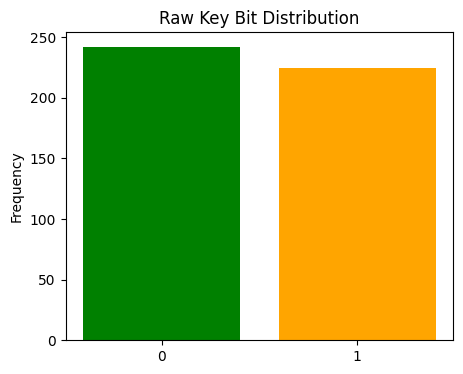

In [39]:
# Using raw_key from earlier
num_zeros = raw_key.count(0)
num_ones = raw_key.count(1)

plt.figure(figsize=(5, 4))
plt.bar(["0", "1"], [num_zeros, num_ones], color=['green', 'orange'])
plt.title("Raw Key Bit Distribution")
plt.ylabel("Frequency")
plt.show()
